In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import FinanceDataReader as fdr

import torch
import torch.nn as nn

In [2]:
data = fdr.DataReader('000660')
data.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2000-04-21,445593,447556,422037,422037,4409900,NaN
2000-04-24,412222,427926,404370,424000,5294570,0.004651
2000-04-25,412222,418111,406333,411240,3623120,-0.030094
2000-04-26,422037,426944,350389,350388,30856280,-0.147972
2000-04-27,323889,333704,298370,317018,41861610,-0.095237


In [3]:
data = data[['Close']]
data

,Close
Date,
2000-04-21,422037
2000-04-24,424000
2000-04-25,411240
2000-04-26,350388
2000-04-27,317018
...,...
2024-08-05,156100
2024-08-06,163700
2024-08-07,169300


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
# plt.plot(data)

In [6]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2000-05-03,341555,341555.0,345481.0,317018.0,350388.0,411240.0,424000.0,422037.0
2000-05-04,343518,341555.0,341555.0,345481.0,317018.0,350388.0,411240.0,424000.0
2000-05-08,350388,343518.0,341555.0,341555.0,345481.0,317018.0,350388.0,411240.0
2000-05-09,342537,350388.0,343518.0,341555.0,341555.0,345481.0,317018.0,350388.0
2000-05-10,335666,342537.0,350388.0,343518.0,341555.0,341555.0,345481.0,317018.0
...,...,...,...,...,...,...,...,...
2024-08-05,156100,173200.0,193300.0,194600.0,188900.0,195600.0,191800.0,190000.0
2024-08-06,163700,156100.0,173200.0,193300.0,194600.0,188900.0,195600.0,191800.0
2024-08-07,169300,163700.0,156100.0,173200.0,193300.0,194600.0,188900.0,195600.0


In [7]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np

array([[341555., 341555., 345481., ..., 411240., 424000., 422037.],
       [343518., 341555., 341555., ..., 350388., 411240., 424000.],
       [350388., 343518., 341555., ..., 317018., 350388., 411240.],
       ...,
       [169300., 163700., 156100., ..., 194600., 188900., 195600.],
       [163400., 169300., 163700., ..., 193300., 194600., 188900.],
       [170000., 163400., 169300., ..., 173200., 193300., 194600.]])

In [8]:
shifted_df_as_np.shape

(5993, 8)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)
shifted_df_as_np

array([[ 0.41719722,  0.41719722,  0.43361455, ...,  0.70859861,
         0.76195703,  0.75374837],
       [ 0.42540589,  0.41719722,  0.41719722, ...,  0.45413413,
         0.70859861,  0.76195703],
       [ 0.45413413,  0.42540589,  0.41719722, ...,  0.31459098,
         0.45413413,  0.70859861],
       ...,
       [-0.30312059, -0.32653808, -0.35831896, ..., -0.19732372,
        -0.22115937, -0.19314202],
       [-0.32779259, -0.30312059, -0.32653808, ..., -0.20275992,
        -0.19732372, -0.22115937],
       [-0.3001934 , -0.32779259, -0.30312059, ..., -0.28681198,
        -0.20275992, -0.19732372]])

In [10]:
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]
X.shape, y.shape

((5993, 7), (5993,))

In [11]:
X = dc(np.flip(X, axis=1))
X

array([[ 0.75374837,  0.76195703,  0.70859861, ...,  0.31459098,
         0.43361455,  0.41719722],
       [ 0.76195703,  0.70859861,  0.45413413, ...,  0.43361455,
         0.41719722,  0.41719722],
       [ 0.70859861,  0.45413413,  0.31459098, ...,  0.41719722,
         0.41719722,  0.42540589],
       ...,
       [-0.19314202, -0.22115937, -0.19732372, ..., -0.28681198,
        -0.35831896, -0.32653808],
       [-0.22115937, -0.19732372, -0.20275992, ..., -0.35831896,
        -0.32653808, -0.30312059],
       [-0.19732372, -0.20275992, -0.28681198, ..., -0.32653808,
        -0.30312059, -0.32779259]])

In [12]:
split_index = int(len(X) * 0.95)
split_index

5693

## Train the model

In [13]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5693, 7), (300, 7), (5693,), (300,))

In [14]:
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5693, 7, 1), (300, 7, 1), (5693, 1), (300, 1))

In [15]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5693, 7, 1]),
 torch.Size([300, 7, 1]),
 torch.Size([5693, 1]),
 torch.Size([300, 1]))

In [16]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [17]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.332
Batch 200, Loss: 0.053
Batch 300, Loss: 0.027

Val Loss: 0.086
***************************************************

Epoch: 2
Batch 100, Loss: 0.022
Batch 200, Loss: 0.015
Batch 300, Loss: 0.009

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.008
Batch 200, Loss: 0.009
Batch 300, Loss: 0.008

Val Loss: 0.002
***************************************************

Epoch: 4
Batch 100, Loss: 0.005
Batch 200, Loss: 0.005
Batch 300, Loss: 0.006

Val Loss: 0.008
***************************************************

Epoch: 5
Batch 100, Loss: 0.003
Batch 200, Loss: 0.003
Batch 300, Loss: 0.003

Val Loss: 0.013
***************************************************

Epoch: 6
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.001

Val Loss: 0.010
***************************************************

Epoch: 7
Batch 100, Loss: 0.002
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.006
*****************

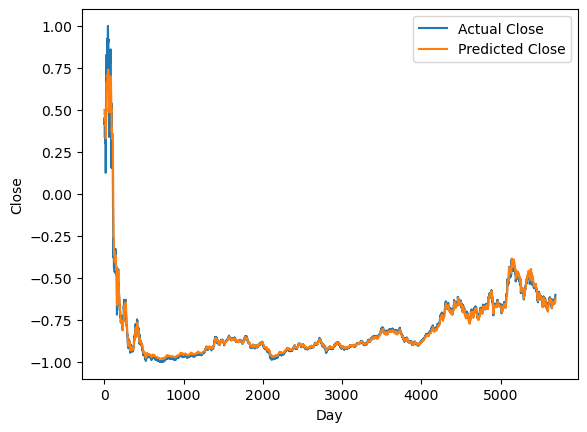

In [23]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()